In [11]:
#import face_recognition  #not used in this project yet
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import pandas as pd
import os
import csv
import numpy as np

import time
import threading

from fastai.vision import *
from fastai.metrics import error_rate
import re

In [8]:
path = Path("data/numdet/numdet_png")
tfms = get_transforms(do_flip=False)
path_files_num_all = list(path.glob('**/*.jpg'))

In [67]:

#"mix_0_0.jpg","!mix_no_2.jpg"
pat = "([\w!]+)_[no0-9]+_\d+\.jpg$"
data = ImageDataBunch.from_name_re(path, path_files_num_all, pat=pat, ds_tfms=tfms) #, size=24

#n = re.search(pat,"!mix_no_200.jpg")
#n.group(1)

In [70]:
data.classes

['!mix', 'mix']

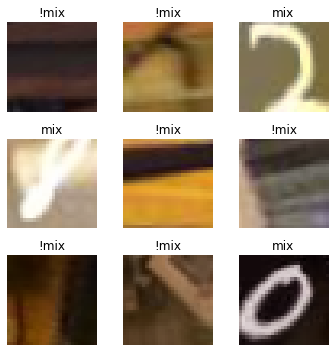

In [71]:
data.show_batch(rows=3, figsize=(5,5))

In [72]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [03:48<00:00, 205kB/s] 


In [73]:
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.121609,0.070518,0.973786,24:32
1,0.064756,0.041609,0.986000,14:11


In [75]:
learn.export('numdet_resnet18_full_1.pkl')

In [177]:
data.train_ds[20100][0]

In [171]:
image = cv2.imread("data/testimg_num_none_1.jpg")
image = cv2.resize(image,(28,28), interpolation = cv2.INTER_AREA) 

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
#edged = cv2.Canny(blurred, 50, 200, 255)
edged = cv2.cvtColor(blurred,cv2.COLOR_GRAY2RGB)

#blurred.shape
edged = np.clip(edged, 0, 255)
test_img = Image(np.clip(pil2tensor(edged,np.float32).div_(-255).add_(1).mul_(3), 0, 1)     )



def get_result(model,image):
    list_result = list(model.predict(image)[2])
    max_value = max(list_result)
    max_index = list_result.index(max_value)
    return max_index,max_value

test_result = get_result(learn,test_img)



0

In [90]:
#load learner
learn = load_learner("./data/numdet/numdet_png","numdet_resnet18_full_1.pkl")

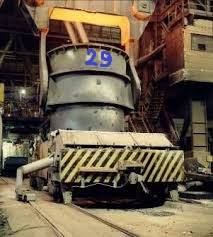

In [159]:
image = cv2.imread("data/test_ladlecar_1.jpg")

cv2pil = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
blurred = cv2.GaussianBlur(cv2pil, (1, 1), 0)
#colored = cv2.cvtColor(blurred,cv2.COLOR_GRAY2RGB)

#colored = np.clip(blurred, 0, 255)
#test_img1 = Image(np.clip(pil2tensor(blurred,np.float32).div_(-255).add_(1), 0, 1))

##2
#test_img2 = open_image('data/testimg_num_1.jpg')
#test_img2 = test_img2.resize((3,26,26))


test_img1 = Image(np.clip(pil2tensor(cv2pil,np.float32).div_(255), 0, 1))
test_img1


Frame has proper size


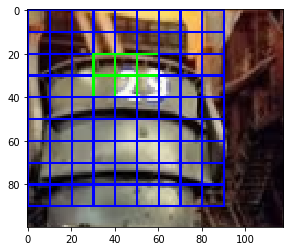

In [200]:
#picture processing
image = cv2.imread("data/test_ladlecar_1.jpg")

#conver to cv2->PIL: BGR->RGB!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

#initial size
h0,w0 = image.shape[:2]

#crop
h1,w1,h1_off,w1_off = 110,130,20,40
image = image[h1_off:h1+h1_off,w1_off:w1+w1_off,:]

#resize
h2 = 100
w2 = int(h2*w1/h1)
image = cv2.resize(image,(w2,h2), interpolation = cv2.INTER_AREA)
image_duplicate = image.copy()
#define parsing frame. Should consist of "windows"
win_h,win_w,h_step,w_step,h_count,w_count = 20,20,10,10,8,8
frame_h = h_step*(h_count-1)+win_h
frame_w = w_step*(w_count-1)+win_w

def get_result(model,image):
    list_result = list(model.predict(image)[2])
    max_value = max(list_result)
    max_index = list_result.index(max_value)
    return max_index,max_value

predict_list = []
img_list = []
if frame_h<h2 and frame_w<w2:
    print("Frame has proper size")
    for h in range(h_count):
        for w in range(w_count):
            
            test_img_cv = image[h*h_step:win_h+h*h_step,w*w_step:win_w+w*w_step,:]
            test_img_cv = cv2.resize(test_img_cv,(28,28), interpolation = cv2.INTER_AREA)
            #gray = cv2.cvtColor(test_img_cv, cv2.COLOR_BGR2GRAY)
            #blurred = cv2.GaussianBlur(gray, (1, 1), 0)
            #colored = cv2.cvtColor(blurred,cv2.COLOR_GRAY2RGB)
            #colored = np.clip(colored, 0, 255)
            test_img_cv = Image(np.clip(pil2tensor(test_img_cv,np.float32).div_(255), 0, 1))
            img_list.append(test_img_cv)
            preduct_result = get_result(learn,test_img_cv)
            predict_list.append(preduct_result)
            if preduct_result[0] == 0:
                image_duplicate = cv2.rectangle(image_duplicate, (w*w_step, h*h_step), (win_w+w*w_step, win_h+h*h_step), (0, 0, 255), 1)
            else:
                image_duplicate = cv2.rectangle(image_duplicate, (w*w_step, h*h_step), (win_w+w*w_step, win_h+h*h_step), (0, 255, 0), 1)
else:
    print("Error: Frame is bigger than image")



#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #for testing
plt.imshow(image_duplicate,)


#for i in range(len(predict_list)):
#    img_list[i].show(title = predict_list[i],figsize=(3,3))

Error: Frame is bigger than image


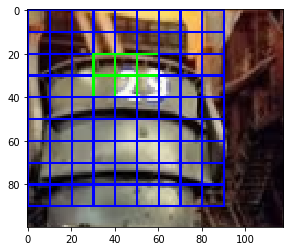

In [214]:



def get_result(model,image):
    list_result = list(model.predict(image)[2])
    max_value = max(list_result)
    max_index = list_result.index(max_value)
    return max_index,max_value

predict_list = []
img_list = []
if frame_h<h2 and frame_w<w2:
    print("Frame has proper size")
    for h in range(h_count):
        for w in range(w_count):
            
            test_img_cv = image[h*h_step:win_h+h*h_step,w*w_step:win_w+w*w_step,:]
            test_img_cv = cv2.resize(test_img_cv,(28,28), interpolation = cv2.INTER_AREA)
            #gray = cv2.cvtColor(test_img_cv, cv2.COLOR_BGR2GRAY)
            #blurred = cv2.GaussianBlur(gray, (1, 1), 0)
            #colored = cv2.cvtColor(blurred,cv2.COLOR_GRAY2RGB)
            #colored = np.clip(colored, 0, 255)
            test_img_cv = Image(np.clip(pil2tensor(test_img_cv,np.float32).div_(255), 0, 1))
            img_list.append(test_img_cv)
            preduct_result = get_result(learn,test_img_cv)
            predict_list.append(preduct_result)
            if preduct_result[0] == 0:
                image_duplicate = cv2.rectangle(image_duplicate, (w*w_step, h*h_step), (win_w+w*w_step, win_h+h*h_step), (0, 0, 255), 1)
            else:
                image_duplicate = cv2.rectangle(image_duplicate, (w*w_step, h*h_step), (win_w+w*w_step, win_h+h*h_step), (0, 255, 0), 1)
else:
    print("Error: Frame is bigger than image")



#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #for testing
plt.imshow(image_duplicate,)


#for i in range(len(predict_list)):
#    img_list[i].show(title = predict_list[i],figsize=(3,3))



def get_num_roi(path,win=[20,20,10,10],crop=[],new_height = 0):
    #picture processing
    image = cv2.imread(path)
    #conver to cv2->PIL: BGR->RGB!!!!!!!!!!!!!!!!!
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    #crop
    if crop:
        h1,w1,h1_off,w1_off = crop[0],crop[1],crop[2],crop[3]
        image = image[h1_off:h1+h1_off,w1_off:w1+w1_off,:]   
    
    h0,w0 = image.shape[:2]
    
    #resize
    if height!= 0: 
        h2 = new_height
        w2 = int(h2*w0/h0)
        image = cv2.resize(image,(w2,h2), interpolation = cv2.INTER_AREA)
        
    image_duplicate = image.copy()
    #define parsing frame. Should consist of "windows"
    win_h,win_w,h_step,w_step = win[0],win[1],win[2],win[3]
    h_count = math.floor(frame_h/h_step-win_h/h_step+1)
    w_count = math.floor(frame_w/w_step-win_w/w_step+1)
    